In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import dash
from dash import dcc,html
import warnings
warnings.filterwarnings('ignore')
import joblib

In [8]:
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

In [ ]:
data = pd.read_csv('data.csv')
actual_cols = list(data.iloc[0])
data.columns = actual_cols
data = data.drop(0)
def parse_time(s):
    try:
        return pd.to_datetime(s, format='%Y-%m-%d %H:%M:%S')
    except:
        return pd.NaT

data['Origin Time'] = data['Origin Time'].apply(parse_time)
valid = data[data['Origin Time'].notna()].sort_values('Origin Time')

# Time intervals (hours)
intervals = valid['Origin Time'].diff().dt.total_seconds() / 3600  # in hours
intervals = intervals[1:]
last_n = 30 if len(intervals) >= 30 else len(intervals)

if last_n > 1:
    X = np.arange(last_n).reshape(-1, 1)
    y = intervals.values[-last_n:]
    model = LinearRegression().fit(X, y)
    next_interval_pred = model.predict([[last_n]])[0]
    next_quake_time = valid['Origin Time'].iloc[-1] + timedelta(hours=next_interval_pred)
else:
    next_quake_time = None
quake_trend = valid[['Origin Time', 'Magnitude']].copy()
quake_trend['Origin Time'] = quake_trend['Origin Time'].astype(str)
quake_trend.to_csv('quake_trend.csv', index=False)

print(f'Last quake: {valid["Origin Time"].iloc[-1]}')
print(f'Next predicted quake: {next_quake_time}')


Last quake: 2025-10-20 07:26:24
Next predicted quake: 2025-10-20 10:41:46.882759


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 1 to 100
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Magnitude                100 non-null    object        
 1   Origin Time              100 non-null    datetime64[ns]
 2   Lat                      100 non-null    object        
 3   Long                     100 non-null    object        
 4   Depth                    100 non-null    object        
 5   Region                   100 non-null    object        
 6   Location                 100 non-null    object        
 7   Type                     100 non-null    object        
 8   Did You Felt Quake  -->  100 non-null    object        
dtypes: datetime64[ns](1), object(8)
memory usage: 7.2+ KB


In [11]:
data.describe()

,Origin Time
count,100
mean,2025-10-10 06:57:15.689999616
min,2025-09-30 04:28:36
25%,2025-10-04 09:07:10.750000128
50%,2025-10-10 06:14:49.500000
75%,2025-10-16 14:05:39.249999872
max,2025-10-20 07:26:24


In [13]:
data.columns.tolist()

['Magnitude',
 'Origin Time',
 'Lat',
 'Long',
 'Depth',
 'Region',
 'Location',
 'Type',
 'Did You Felt Quake  -->']

In [14]:
data.isna().sum()

Magnitude                  0
Origin Time                0
Lat                        0
Long                       0
Depth                      0
Region                     0
Location                   0
Type                       0
Did You Felt Quake  -->    0
dtype: int64

In [15]:
data.duplicated().sum()

np.int64(0)

In [16]:
data['Magnitude'] = pd.to_numeric(data['Magnitude'], errors='coerce')
data['Origin Time'] = pd.to_datetime(data['Origin Time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
data = data[data['Origin Time'].notna()]

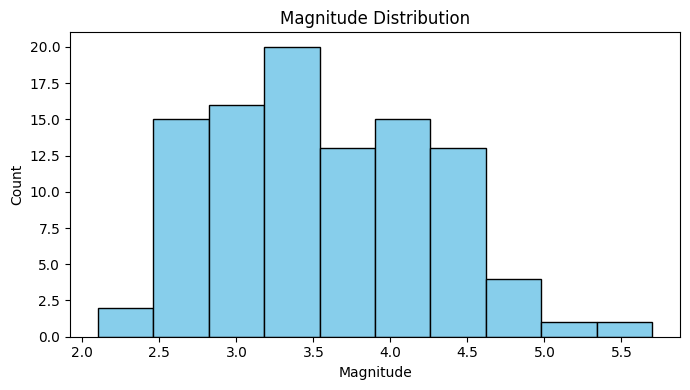

In [17]:
plt.figure(figsize=(7,4))
data['Magnitude'].plot.hist(bins=10, color='skyblue', edgecolor='black')
plt.title('Magnitude Distribution')
plt.xlabel('Magnitude')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('magnitude_histogram.png')
plt.show()

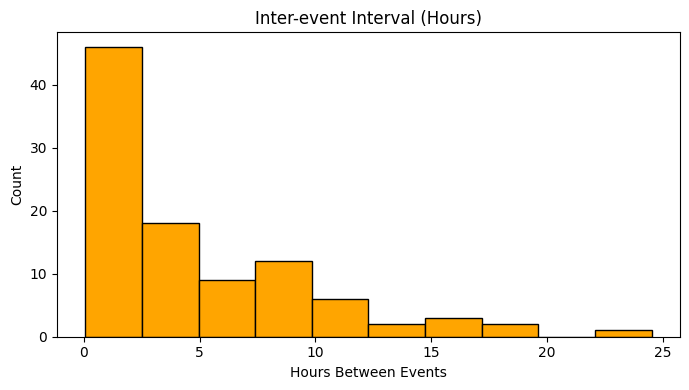

In [18]:
data = data.sort_values('Origin Time')
intervals = data['Origin Time'].diff().dt.total_seconds()/3600   
intervals = intervals[1:]  

plt.figure(figsize=(7,4))
intervals.plot.hist(bins=10, color='orange', edgecolor='black')
plt.title('Inter-event Interval (Hours)')
plt.xlabel('Hours Between Events')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('interval_histogram.png')
plt.show()

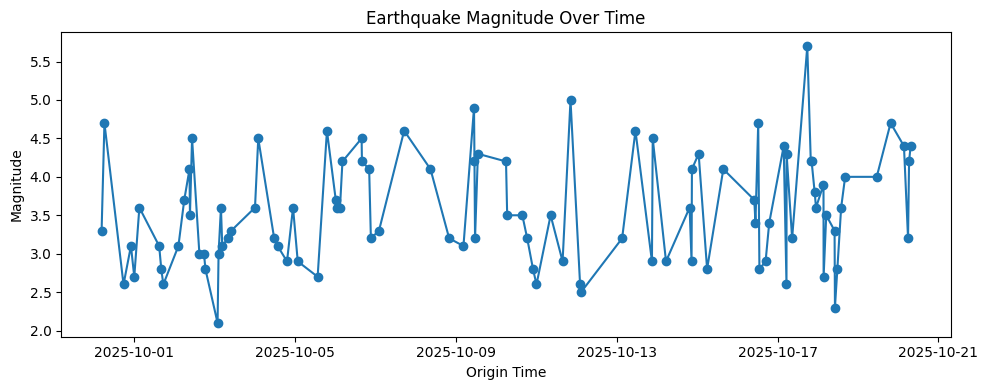

In [19]:
plt.figure(figsize=(10,4))
plt.plot(data['Origin Time'], data['Magnitude'], marker='o', linestyle='-')
plt.title('Earthquake Magnitude Over Time')
plt.xlabel('Origin Time')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.savefig('magnitude_trend.png')
plt.show()

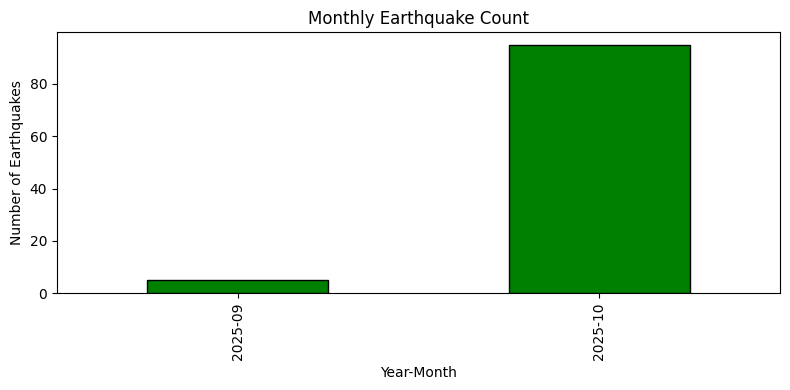

In [20]:
data['YearMonth'] = data['Origin Time'].dt.to_period('M').astype(str)
monthly_counts = data.groupby('YearMonth').size()

plt.figure(figsize=(8,4))
monthly_counts.plot(kind='bar', color='green', edgecolor='black')
plt.title('Monthly Earthquake Count')
plt.xlabel('Year-Month')
plt.ylabel('Number of Earthquakes')
plt.tight_layout()
plt.savefig('monthly_count.png')
plt.show()

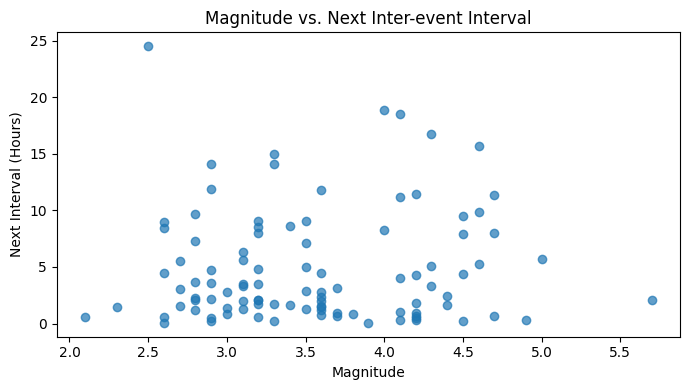

In [21]:
data = data.sort_values('Origin Time')
data['Next Interval (hrs)'] = data['Origin Time'].shift(-1) - data['Origin Time']
data['Next Interval (hrs)'] = data['Next Interval (hrs)'].dt.total_seconds() / 3600
scatter_df = data.iloc[:-1]  

plt.figure(figsize=(7,4))
plt.scatter(scatter_df['Magnitude'], scatter_df['Next Interval (hrs)'], alpha=0.7)
plt.title('Magnitude vs. Next Inter-event Interval')
plt.xlabel('Magnitude')
plt.ylabel('Next Interval (Hours)')
plt.tight_layout()
plt.savefig('magnitude_vs_next_interval.png')
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
valid = data[data['Origin Time'].notna()].sort_values('Origin Time')
valid['Next Interval'] = valid['Origin Time'].shift(-1) - valid['Origin Time']
valid['Next Interval'] = valid['Next Interval'].dt.total_seconds() / 3600 
X = mod[['Magnitude']]
y = mod['Next Interval']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

reg = LinearRegression().fit(X_train, y_train)
pred_y = reg.predict(X_test)
mae = mean_absolute_error(y_test, pred_y)
r2 = r2_score(y_test, pred_y)
coef = reg.coef_[0]
intercept = reg.intercept_

print(f'Mean Absolute Error (hours): {mae}')
print(f'R2 Score: {r2}')
print(f'Regression Coefficient: {coef}')
print(f'Intercept: {intercept}')

Mean Absolute Error (hours): 4.180156138472519
R2 Score: -0.06502603182251998
Regression Coefficient: 0.5155479221191203
Intercept: 3.4386884863986076
